In [1]:
import nbsetup
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import ensemblepy as ep
from ensemblepy.densityvar import spike
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
MODE = 'entropy'

In [4]:
PARAMS = ((20, (-0.1, +1.1), 2000),(20, (-0.1, +1.1), 2000))
vs = {}
for params in PARAMS:
    for d in range(1, 10):
        vs[(*params, d)] = ep.minmax_variance(*params, mode=MODE, dimensions=d)
print(vs)

{(20, (-0.1, 1.1), 2000, 1): (7.51475028267237, 5.901210359337699), (20, (-0.1, 1.1), 2000, 2): (7.46118500367181, 5.653552403556951), (20, (-0.1, 1.1), 2000, 3): (7.446168829092051, 5.4959342181255435), (20, (-0.1, 1.1), 2000, 4): (7.4639353836582405, 5.376646632304124), (20, (-0.1, 1.1), 2000, 5): (7.471501965896817, 5.279732385104471), (20, (-0.1, 1.1), 2000, 6): (6.849303640558336, 5.197856615339348), (20, (-0.1, 1.1), 2000, 7): (6.2492236014813916, 5.1269173302073465), (20, (-0.1, 1.1), 2000, 8): (6.185923121346936, 5.064339529747215), (20, (-0.1, 1.1), 2000, 9): (5.701529739023773, 5.008380589024748)}


In [14]:
def perfect(pp, dimensions=1, count=1000):
    p = int(count*(1-pp))
    
    if p == count: 
        return spike(dimensions, count, val=0.1)
    elif p == 0:
        return np.array([np.random.uniform(0,1,count) for _ in range(dimensions)])
    else:
        s = spike(dimensions, p, val=0.1)
        u = [np.random.uniform(0,1,count-p) for _ in range(dimensions)]
        return np.array([np.concatenate([s[d], u[d]]) for d in range(dimensions)])

def block(pp, dimensions=1, count=5000):
    return np.array([np.random.uniform(0,pp,count) for _ in range(dimensions)])

def normal(pp, dimensions=1, count=10000):
    data = []
    for _ in range(count):
        x = np.random.normal(0.5, pp/10)
        if x <= 1 or x >= 0: data.append(x)
    return np.array([data for _ in range(dimensions)])

In [6]:
def entropies(func, percent=np.linspace(1,0,10), dimensions=(1,3,5), binrange = (3,5), count=1000):
    data = []
    for d in dimensions:
        emax = {}
        for x in percent:
            dist = func(x, d, count)
            dv = ep.density_variance(dist, parameters=PARAMS, mode=MODE, vs=vs)
            
            for b in binrange:    
                pmf = np.histogramdd(dist.T, bins=b, range=[(0,1) for _ in range(d)])[0].flatten()
                ent = sp.stats.entropy(pmf)
                
                try:
                    em = emax[(d,b)]
                except KeyError:
                    emax[(d,b)] = ent
                    em = ent
                
                data.append({
                    'percent': x,
                    'dimension': d,
                    'dv': dv,
                    'ent': ent,
                    'nent': ent/em,
                    'bins': b,
                })
        print(d)
    
    return pd.DataFrame(data)

In [7]:
def plot(data, dvs=False):
    if dvs:
        fig, axes = plt.subplots(1,len(data['di'].unique()), figsize=(20,5), sharey=True)
        for i, di in data['di'].unique():
            sns.lineplot(data=data[data['di']==di], x='percent', y='dv', hue='dimension', ax=axes[i])
    
    fig, axes = plt.subplots(1,len(data['bins'].unique())+1, figsize=(20,5), sharey=True)
    sns.lineplot(data=data, x='percent', y='dv', hue='dimension', ax=axes[0], palette='mako_r').set(title='Density variance')
    for i, b in enumerate(data['bins'].unique()):
        df = data[data['bins']==b]
        sns.lineplot(data=df, x='percent', y='nent', hue='dimension', ax=axes[i+1]).set(title='%s Bins' % b)
    
    fig, axes = plt.subplots(1,len(data['dimension'].unique()), figsize=(20,5), sharey=True)
    for i, d in enumerate(data['dimension'].unique()):
        df = data[data['dimension']==d]
        sns.lineplot(data=df, x='percent', y='nent', hue='bins', ax=axes[i]).set(title='%s Dimensions' % d)
        sns.lineplot(data=df, x='percent', y='dv', ax=axes[i], linestyle='dotted', color='teal').set(title='%s Dimensions' % d)


In [8]:
block_data = entropies(block)

1
3
5


In [15]:
perfect_data = entropies(perfect)

1
3
5


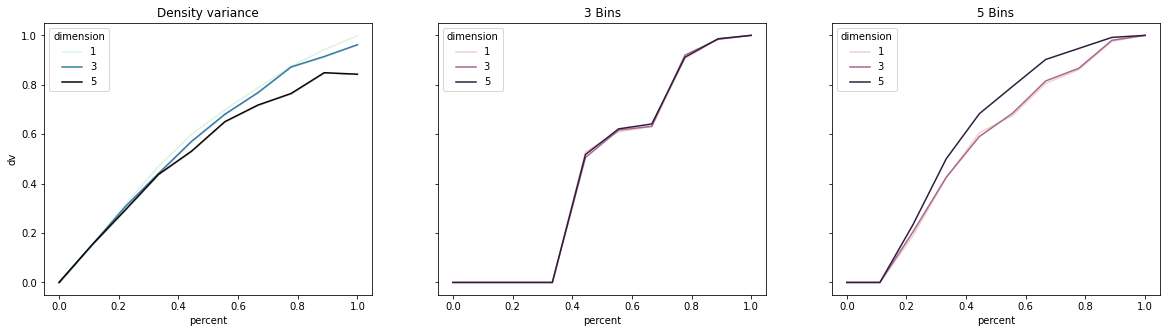

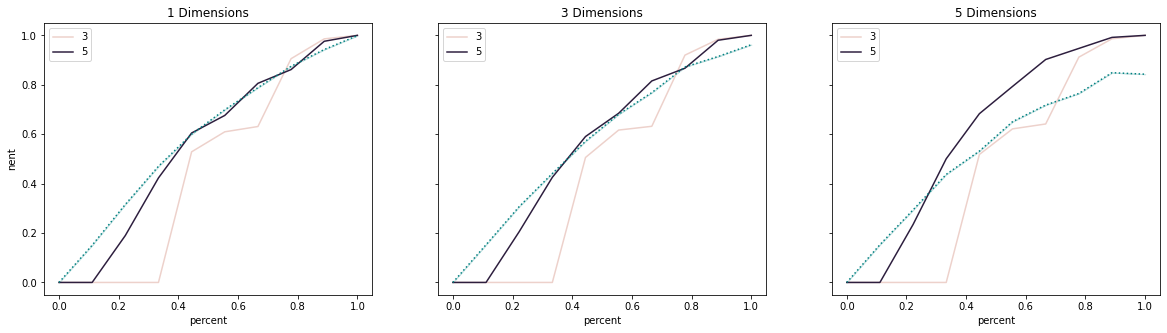

In [10]:
plot(block_data)

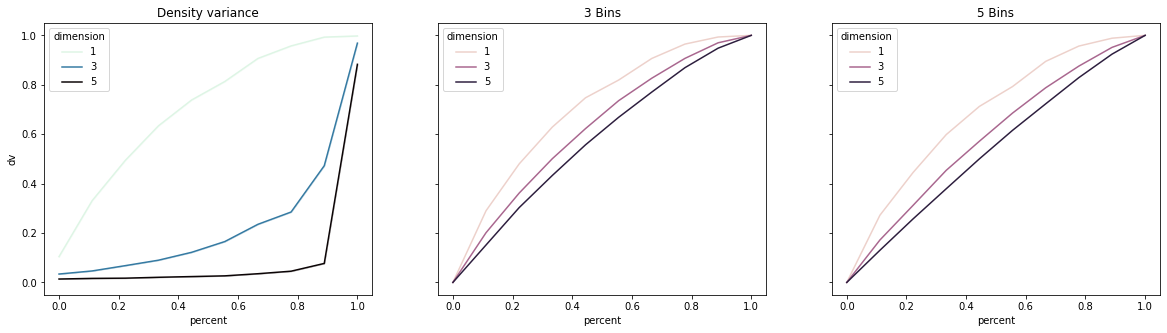

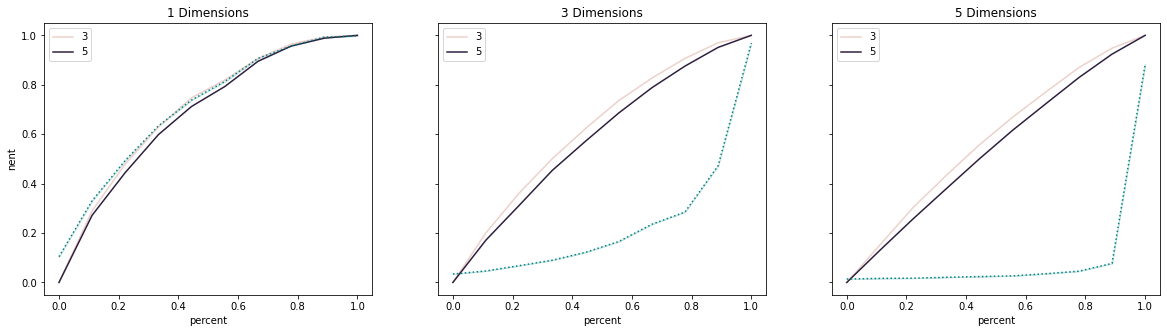

In [16]:
plot(perfect_data)

In [12]:
normal_data = entropies(normal)

1
3
5


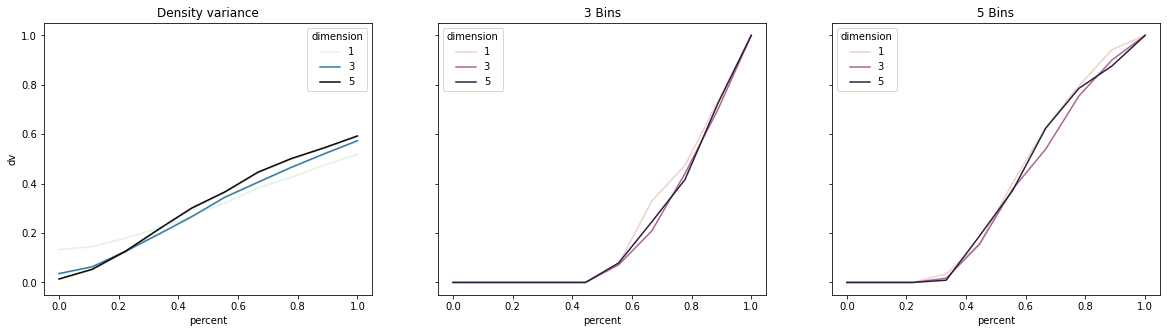

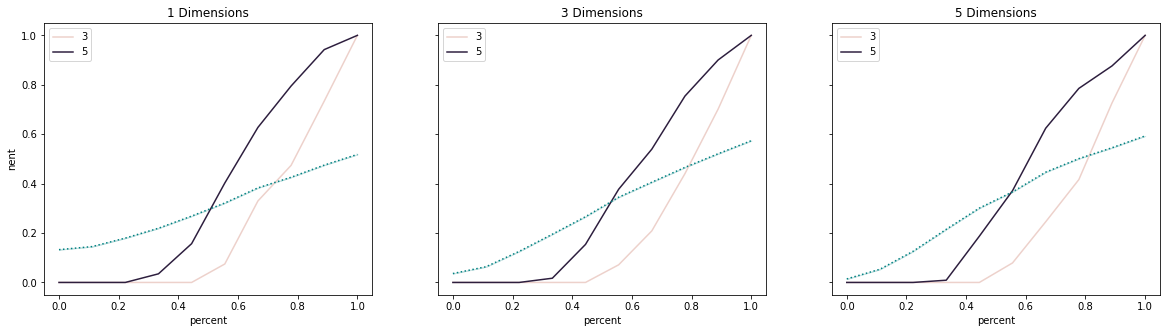

In [13]:
plot(normal_data)

In [64]:
krange = list(range(10,50,5))
params = [(k, (-0.1, +1.1), 1000) for k in krange]
dimensions = list(range(1, 20, 2))
data = []
for d in range(1,20):
    dist = normal(1, d)
    dvs = ep.density_variance(dist, minimum=False, parameters=params)
    for i, k in enumerate(krange):
        data.append({
            'k': k,
            'dimension': d,
            'dv': dvs[i]
        })
data = pd.DataFrame(data)

<AxesSubplot:xlabel='k', ylabel='dv'>

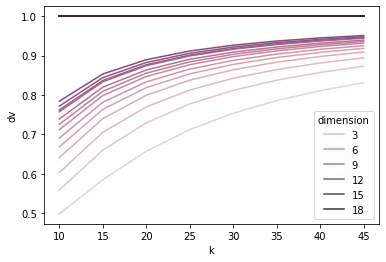

In [65]:
sns.lineplot(data=data, x='k', y='dv', hue='dimension')

<AxesSubplot:xlabel='dimension', ylabel='dv'>

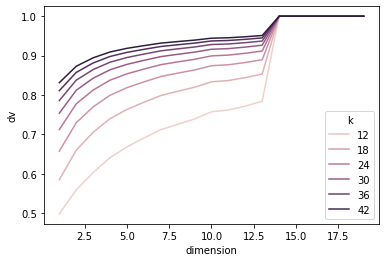

In [67]:
sns.lineplot(data=data, x='dimension', y='dv', hue='k')